# Задание 1

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from scipy.stats import shapiro, kstest, normaltest
from statsmodels.stats.diagnostic import kstest_normal, normal_ad
import yfinance as yf
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
CAT_data = yf.Ticker('CAT')
CAT_df = CAT_data.history(period='1d', start='2017-1-1', end='2022-10-18')
CAT_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-01-03,80.637334,81.658170,79.993951,80.628754,5054900,0.0,0
2017-01-04,81.031944,81.066258,80.148365,80.268463,3772100,0.0,0
2017-01-05,79.933915,81.031954,79.281952,79.779503,4698800,0.0,0
2017-01-06,80.165517,80.294195,79.273365,79.813805,4023100,0.0,0
2017-01-09,79.719458,80.199848,79.093229,79.239067,3095000,0.0,0


In [3]:
NOV_data = yf.Ticker('NOV')
NOV_df = NOV_data.history(period='1d', start='2017-1-1', end='2022-10-18')
NOV_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-01-03,36.767170,37.355523,35.870174,36.468174,4086300,0.0,0
2017-01-04,36.429594,37.423039,36.342787,37.162621,3242000,0.0,0
2017-01-05,37.288006,37.596649,36.960072,37.297649,2946100,0.0,0
2017-01-06,37.297650,37.808843,36.767169,37.606297,2916200,0.0,0
2017-01-09,37.201204,37.750975,36.603208,36.718948,3266900,0.0,0


In [4]:
CAT_df = pd.DataFrame(CAT_df['Close'])
NOV_df = pd.DataFrame(NOV_df['Close'])

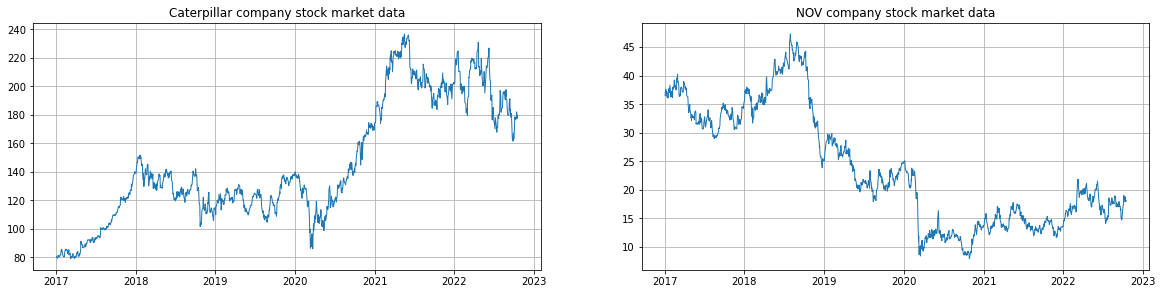

In [5]:
plt.figure(figsize=(20,10))

plt.subplot(2, 2, 1)
plt.plot(CAT_df.Close, linewidth='1')
plt.grid(True)
plt.title('Caterpillar company stock market data')

plt.subplot(2, 2, 2)
plt.plot(NOV_df.Close, linewidth='1')
plt.grid(True)
plt.title('NOV company stock market data');

Посмотрим на основные статистики рядов:

,Close
count,1458.000000
mean,145.501648
std,42.042874
min,79.048851
25%,116.294619
50%,131.276886
75%,185.531876
max,236.585022


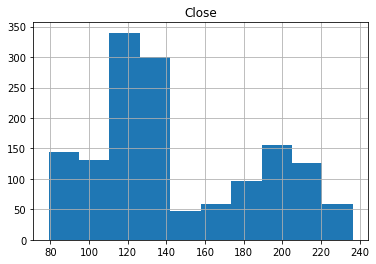

In [6]:
CAT_stat = CAT_df.describe()
CAT_df.hist()
CAT_stat

На первый взгляд, по гистограмме и основным характеристикам, ряд не является нормальным. Проведем тестирование, чтобы убедиться:

In [7]:
def is_normal(test, p_level=0.05):
    stat, pval = test
    return f'Normal, p_val={pval}' if pval > p_level else f'Not Normal, p_val={pval}'

In [8]:
normal_args = (np.mean(CAT_df),np.std(CAT_df))

print(is_normal(shapiro(CAT_df)))
print(is_normal(normaltest(CAT_df)))
print(is_normal(normal_ad(CAT_df)))
print(is_normal(kstest_normal(CAT_df)))
print(is_normal(kstest(CAT_df,
                   cdf='norm',
                   args=normal_args)))

Not Normal, p_val=8.304621475777427e-27
Not Normal, p_val=[4.06086321e-75]
Not Normal, p_val=0.0
Not Normal, p_val=0.0009999999999998899
Not Normal, p_val=0.0


,Close
count,1458.000000
mean,23.603122
std,10.189159
min,7.916168
25%,14.448734
50%,20.896056
75%,32.696589
max,47.285572


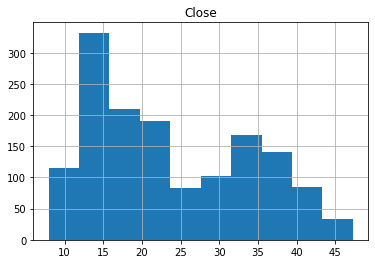

In [9]:
NOV_stat = NOV_df.describe()
NOV_df.hist()
NOV_stat

На первый взгляд, по гистограмме и основным характеристикам, ряд не является нормальным. Проведем тестирование, чтобы убедиться:

In [10]:
normal_args = (np.mean(NOV_df),np.std(NOV_df))

print(is_normal(shapiro(NOV_df)))
print(is_normal(normaltest(NOV_df)))
print(is_normal(normal_ad(NOV_df)))
print(is_normal(kstest_normal(NOV_df)))
print(is_normal(kstest(NOV_df,
                   cdf='norm',
                   args=normal_args)))

Not Normal, p_val=4.041027193102515e-26
Not Normal, p_val=[1.01981398e-130]
Not Normal, p_val=0.0
Not Normal, p_val=0.0009999999999998899
Not Normal, p_val=0.0


Таким образом, вероятнее всего оба ряда не являются нормальными, поскольку все тестирования отвергают нулевую гипотезу о нормальности ряда (p_val < 0,05).

Попробуем разложить временной ряд на компоненты, чтобы более явно увидеть тренд и, возможно, сезонность:

In [11]:
def decompose(df1, df2, df1_name, df2_name, column_name):

    dec1 = seasonal_decompose(df1[column_name], model = 'additive', extrapolate_trend='freq')
    dec2 = seasonal_decompose(df2[column_name], model = 'additive', extrapolate_trend='freq')

    plt.rcParams.update({'figure.figsize': (20, 10)})
    dec1.plot().suptitle(f'{df1_name} Decompose', y = 1.05, fontsize=30)
    dec2.plot().suptitle(f'{df2_name} Decompose', y = 1.05, fontsize=30)
    plt.show()
    
    return 

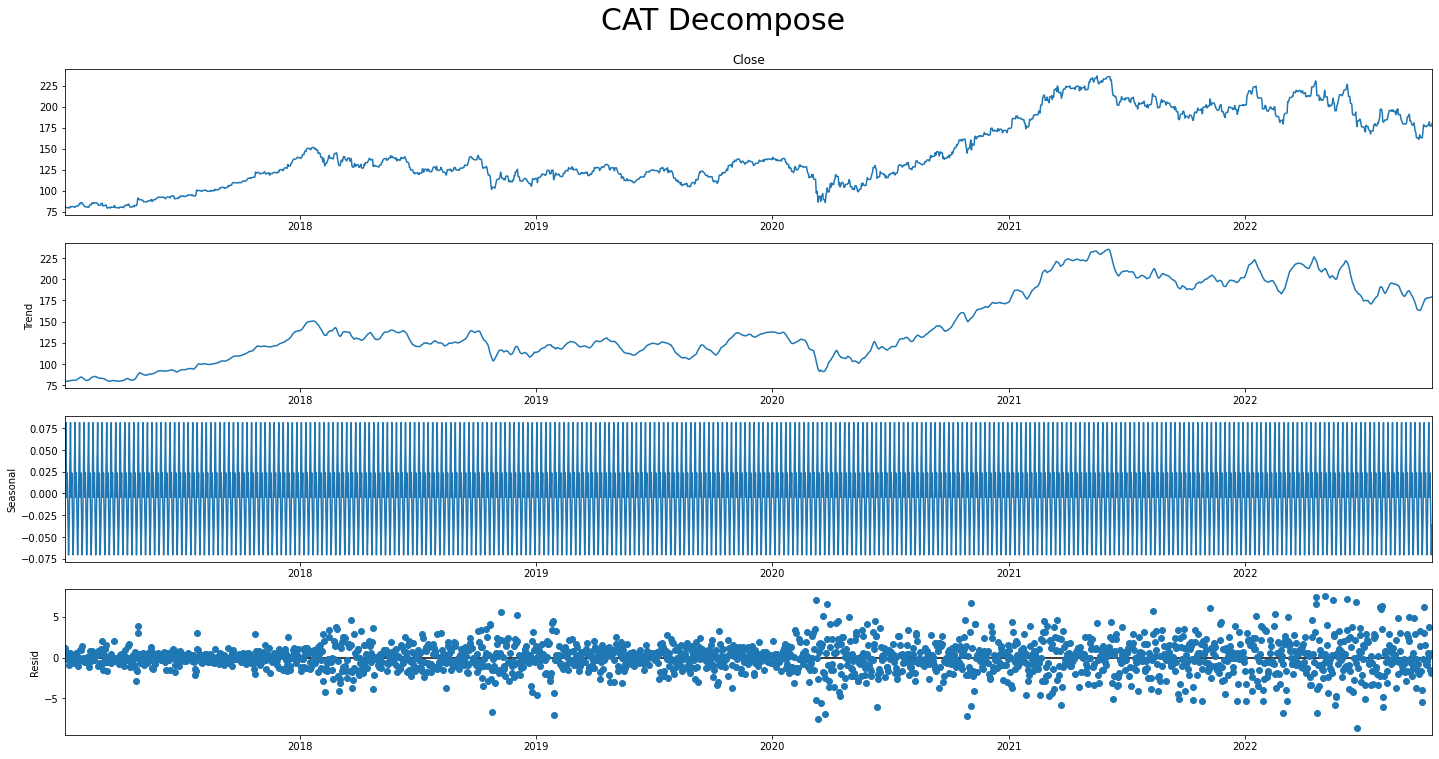

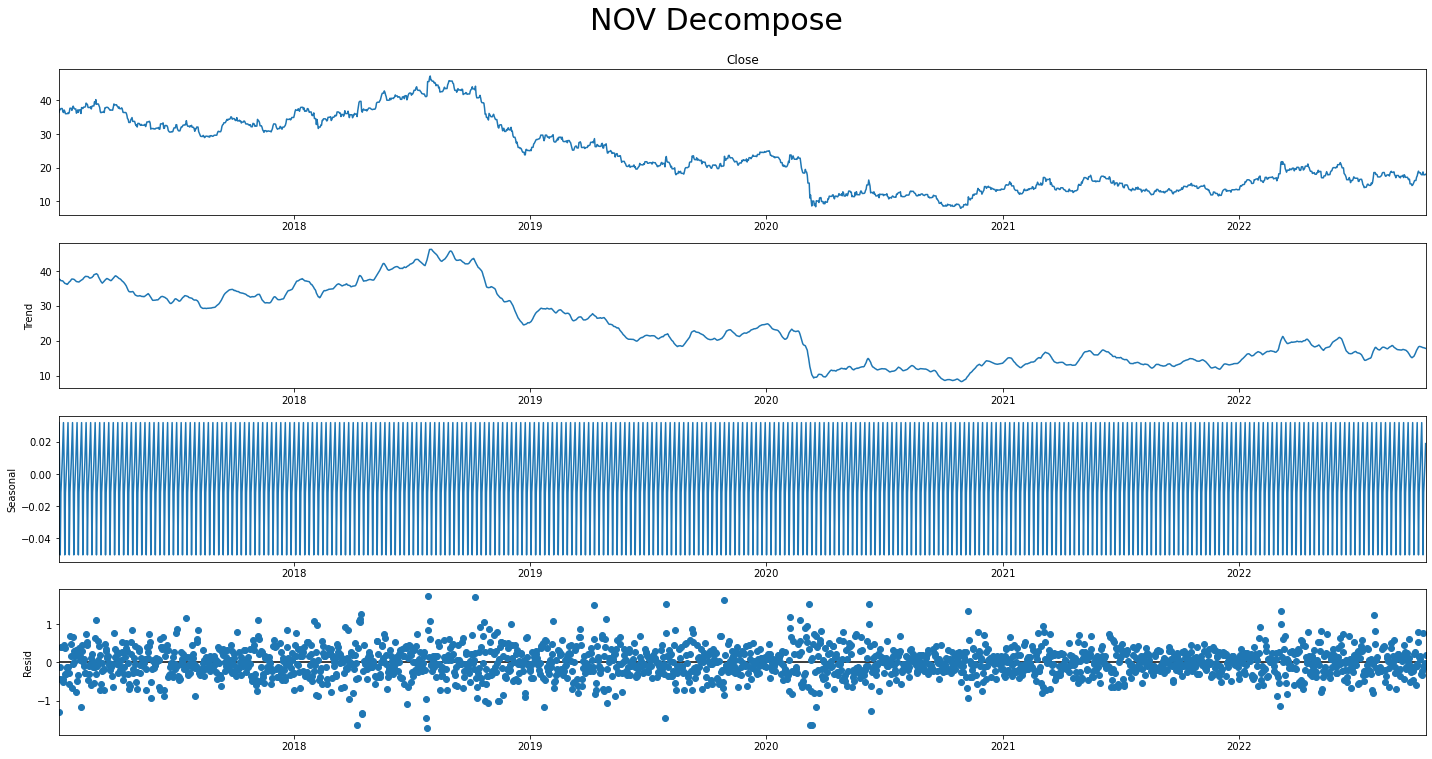

In [12]:
decompose(CAT_df.asfreq('d').ffill(), NOV_df.asfreq('d').ffill(), 'CAT', 'NOV', 'Close')

По графикам видно, что вероятнее всего оба временных ряда не являются стационарными, в них присутствует некий тренд и вероятно сезонная компонента. Для того, чтобы убедиться в их нестационарности, проведем тест Дики-Фуллера: 

In [13]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
    
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

### Анализ стационарности для акций CAT:

Results of Dickey-Fuller Test:
Test Statistic                   -1.638385
p-value                           0.463105
#Lags Used                        0.000000
Number of Observations Used    1457.000000
Critical Value (1%)              -3.434846
Critical Value (5%)              -2.863526
Critical Value (10%)             -2.567827
dtype: float64


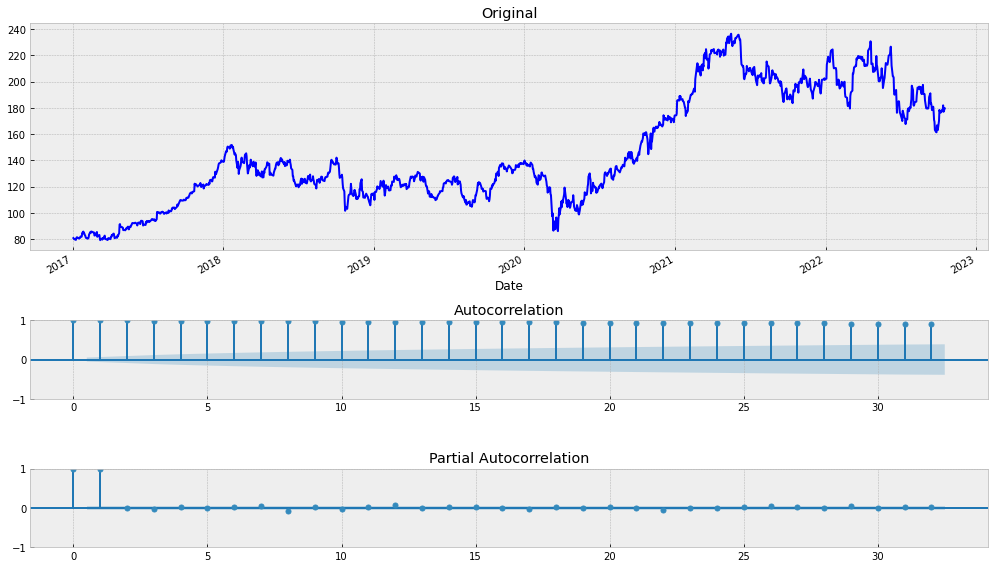

In [14]:
tsplot(CAT_df.Close)

Из p-value и графиков видно, что тест Дики-Фулера не отвергает гипотезу о нестационарности временного ряда. Попробуем убрать размах дисперсии при помощи преобразования Бокса-Кокса:

Results of Dickey-Fuller Test:
Test Statistic                   -1.820306
p-value                           0.370428
#Lags Used                       13.000000
Number of Observations Used    1444.000000
Critical Value (1%)              -3.434887
Critical Value (5%)              -2.863544
Critical Value (10%)             -2.567837
dtype: float64


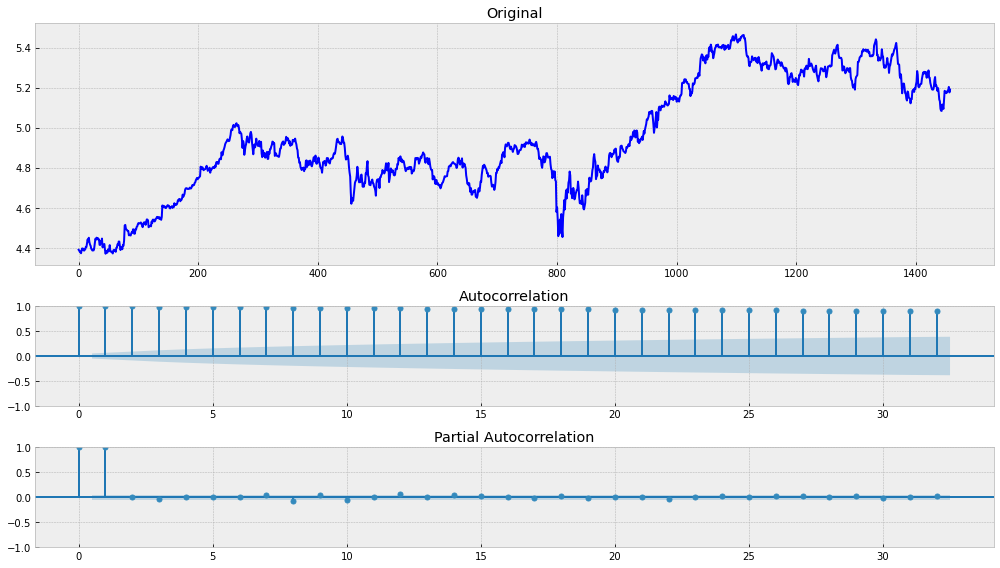

In [15]:
CAT_transform = boxcox(CAT_df.Close, 0)
tsplot(CAT_transform)

Из p-value и графиков видно, что тест Дики-Фулера снова не отвергает гипотезу о нестационарности временного ряда. Попробуем воспользоваться дифференцированием, чтобы убрать тренд: 

Results of Dickey-Fuller Test:
Test Statistic                -1.155266e+01
p-value                        3.417670e-21
#Lags Used                     1.200000e+01
Number of Observations Used    1.444000e+03
Critical Value (1%)           -3.434887e+00
Critical Value (5%)           -2.863544e+00
Critical Value (10%)          -2.567837e+00
dtype: float64


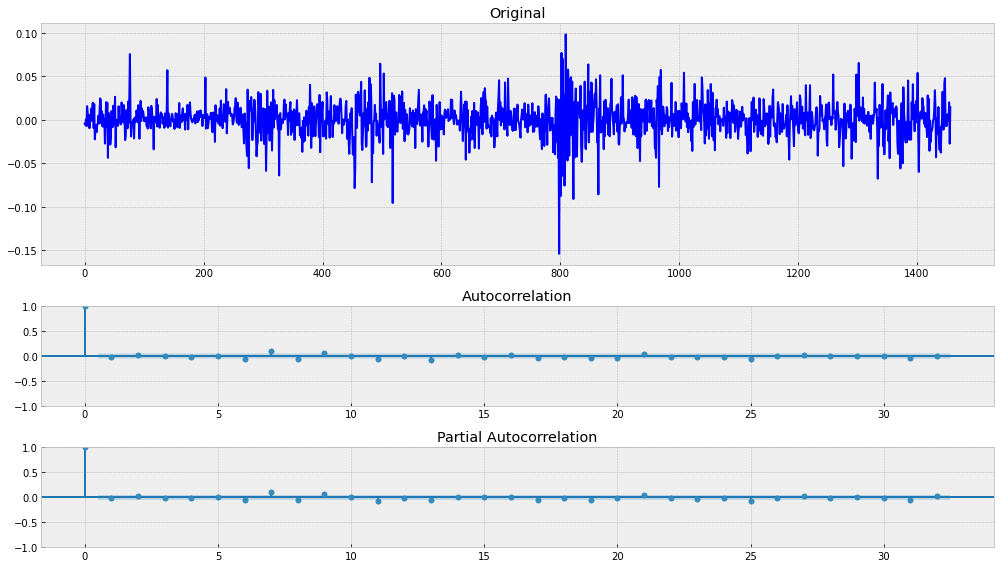

In [16]:
CAT_transform = CAT_transform[1:] - CAT_transform[:-1]
tsplot(CAT_transform)

Теперь p-value стремится к 0 (т.е. меньше 0,05), а график временного ряда внешне напоминает белый шум, можем сделать вывод, что удалось добиться стационарности временного ряда. 

### Анализ стационарности для акций NOV:

Results of Dickey-Fuller Test:
Test Statistic                   -1.443862
p-value                           0.561077
#Lags Used                        0.000000
Number of Observations Used    1457.000000
Critical Value (1%)              -3.434846
Critical Value (5%)              -2.863526
Critical Value (10%)             -2.567827
dtype: float64


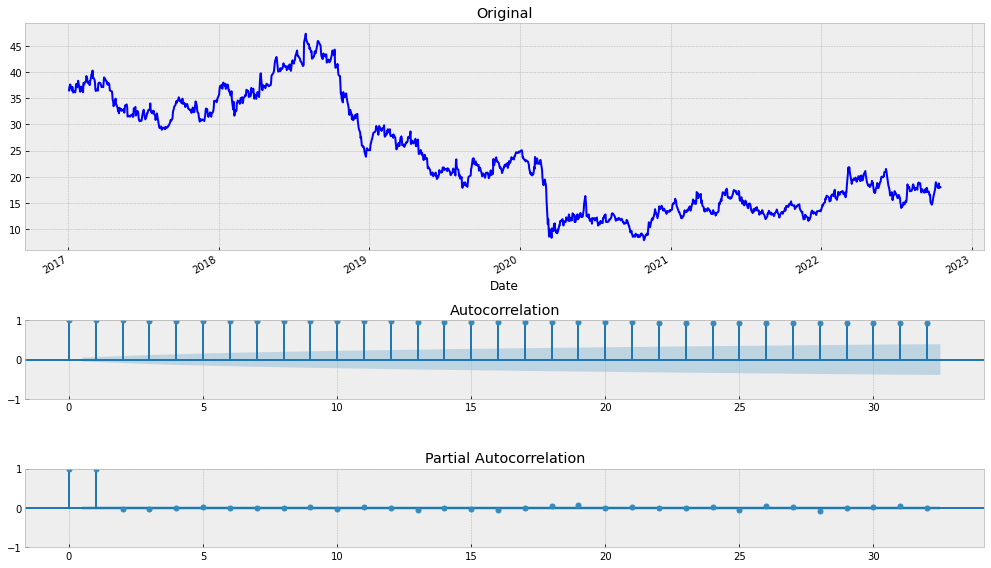

In [20]:
tsplot(NOV_df.Close)

Из p-value и графиков видно, что тест Дики-Фулера и для этого временного ряда сразу не отвергает гипотезу о нестационарности ряда. Попробуем убрать размах дисперсии при помощи преобразования Бокса-Кокса:

Results of Dickey-Fuller Test:
Test Statistic                   -1.693989
p-value                           0.434212
#Lags Used                        7.000000
Number of Observations Used    1450.000000
Critical Value (1%)              -3.434868
Critical Value (5%)              -2.863535
Critical Value (10%)             -2.567832
dtype: float64


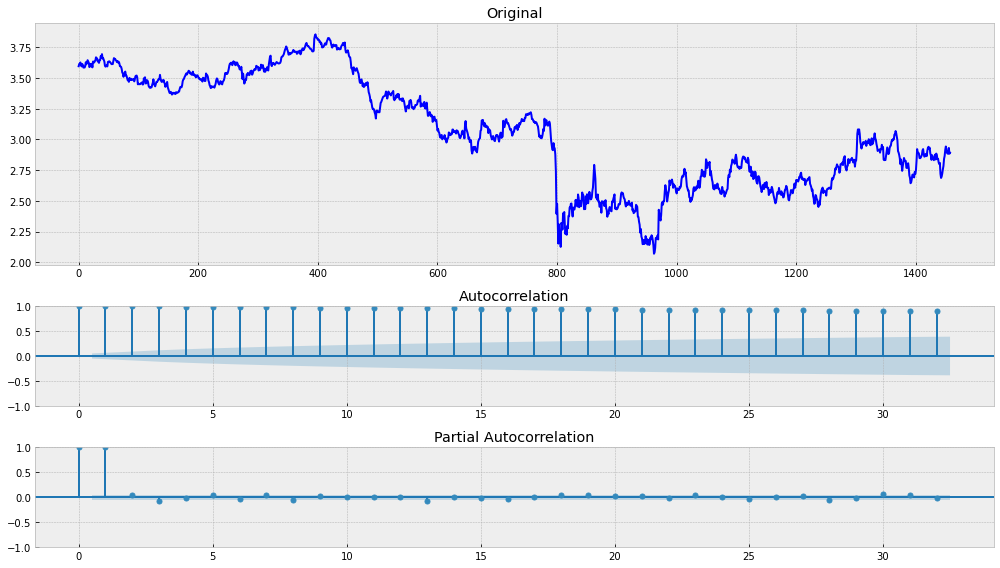

In [21]:
NOV_transform = boxcox(NOV_df.Close, 0)
tsplot(NOV_transform)

Из p-value и графиков видно, что тест Дики-Фулера снова не отвергает гипотезу о нестационарности временного ряда. Попробуем воспользоваться дифференцированием, чтобы убрать тренд:

Results of Dickey-Fuller Test:
Test Statistic                -1.395536e+01
p-value                        4.621987e-26
#Lags Used                     6.000000e+00
Number of Observations Used    1.450000e+03
Critical Value (1%)           -3.434868e+00
Critical Value (5%)           -2.863535e+00
Critical Value (10%)          -2.567832e+00
dtype: float64


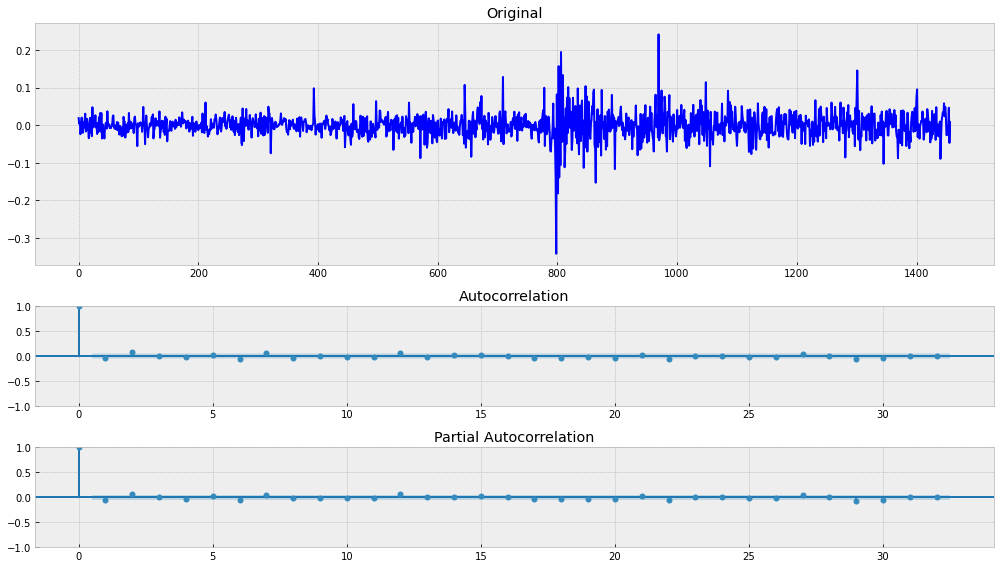

In [22]:
NOV_transform = NOV_transform[1:] - NOV_transform[:-1]
tsplot(NOV_transform)

Теперь p-value стремится к 0 (т.е. меньше 0,05), можем сделать вывод, что удалось добиться стационарности временного ряда.